# Plotting temperature and photosynthesis-related GO term counts, normalised by number of InterPro annotations, for Tara Oceans project PRJEB1787.

This task shows how to analysie metadata and annotations retrieved from the EMG API and combined on the fly to generate the visualisations.

In [1]:
from jsonapi_client import Session, Filter

def find_meta(metadata, key):
    for m in metadata:
        if m.var_name.lower() == key.lower():
            return m.var_value
    return None

metadata_key = 'temperature'
normilize_meta_key = 'Total InterProScan matches'

result = {}

with Session('https://www.ebi.ac.uk/metagenomics/api/v0.2/') as s:

    run_meta_mapping = {}
    missing_temp = list()
    
    print('Loading data from API.', end='', flush=True)
    # list samples
    f = Filter('study_accession=ERP001736')
    for run in s.iterate('runs', f):
        print('.', end='', flush=True)
        for m in run.sample.metadata:
            if m.var_name.lower() == metadata_key.lower():
                m_value = int(float(m.var_value))
                run_meta_mapping[run.accession] = m_value
        # if missing
        try:
            run_meta_mapping[run.accession]
        except KeyError:
            missing_temp.append(run.accession)

        for anls in run.analysis:

            for _m in anls.metadata:
                if _m.var_name.lower() == normilize_meta_key.lower():
                    ipr_count = _m.var_value

            _key = run_meta_mapping[anls.accession]
            try:
                result[_key]
            except KeyError:
                result[_key] = {}

            rt = "runs/%s/pipelines/%s/go-slim" % (anls.accession, anls.pipeline_version)
            _f = Filter('page_size=100')
            for a in s.iterate(rt, _f):
                try:
                    result[_key][a.accession]
                except KeyError:
                    result[_key][a.accession] = list()
                _z = float(a.count)/int(ipr_count)
                result[_key][a.accession].append(_z)
    print("DONE")
    print("Missing: ", missing_temp)

Loading data from API..........................................................................................................................................................................................................................................................DONE
Missing:  []


### Clean up data
remove invalid values and calculate average of counts

In [2]:
import numpy as np
import copy

for k in copy.deepcopy(list(result.keys())):
    if k > 1000:
        del result[k]
for k in result:
    for k1 in result[k]:
        result[k][k1] = np.mean(result[k][k1])

### Plot

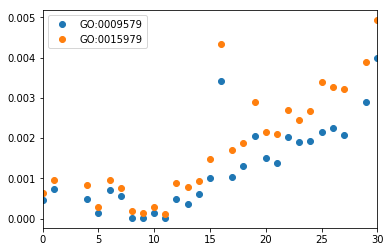

In [3]:
import matplotlib.pyplot as plt
from pandas import DataFrame

df = DataFrame(result).T.fillna(0)

df.plot(y=['GO:0009579', 'GO:0015979'], use_index=True, style='o')

plt.show()

### Calculate correlation

In [4]:
from scipy.stats import spearmanr
df = DataFrame(result).T.fillna(0)
x = df.index.tolist()
correl = []
correl_p = []
for k in df.keys():
    y = list(df[k])
    rho, p = spearmanr(x, y)

    correl.append(rho)
    correl_p.append(p)
df.loc['rho'] = correl
df.loc['p'] = correl_p

In [5]:
df[['GO:0009579','GO:0015979']]

,GO:0009579,GO:0015979
0,4.644260e-04,6.412519e-04
1,7.436903e-04,9.478596e-04
4,4.866566e-04,8.416406e-04
5,1.424872e-04,2.853201e-04
6,7.041597e-04,9.503693e-04
7,5.550468e-04,7.563515e-04
8,1.575606e-05,1.966229e-04
9,2.477207e-05,1.328084e-04
10,1.487709e-04,2.954467e-04
11,1.753299e-05,1.251089e-04
